In [1]:
from nuscenes.nuscenes import NuScenes
root_path = '/extssd/jiaxin/nuscenes'
nusc = NuScenes(version='v1.0-trainval', dataroot=root_path, verbose=True)
   

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 20.1 seconds.
Reverse indexing ...
Done reverse indexing in 5.5 seconds.


In [46]:
import numpy as np
import os
import time
import math
from pyquaternion import Quaternion
    

In [10]:
# get daytime scenes
daytime_scene_list = []
for scene in nusc.scene:
    if 'night' in scene['description'] or 'Night' in scene['description']:
        continue
    else:
        daytime_scene_list.append(scene['token'])

# train val split
print(len(daytime_scene_list))


751


In [30]:
scene = nusc.get('scene', '73030fb67d3c46cfb5e590168088ae39')
print(scene.keys())

first_sample_token = scene['first_sample_token']
first_sample = nusc.get('sample', first_sample_token)

print(first_sample.keys())

sensor = 'CAM_FRONT'
cam_front_data = nusc.get('sample_data', first_sample['data'][sensor])
print(cam_front_data.keys())

cam_front_calib = nusc.get('calibrated_sensor', cam_front_data['calibrated_sensor_token'])
print(cam_front_calib.keys())

sensor = 'LIDAR_TOP'
lidar_data = nusc.get("sample_data", first_sample['data'][sensor])
print(lidar_data.keys())

lidar_data_next = nusc.get('sample_data', lidar_data['next'])
init_sample_token = lidar_data_next['sample_token']
init_scene_token = nusc.get('sample', init_sample_token)['scene_token']
print(lidar_data_next)

dict_keys(['token', 'log_token', 'nbr_samples', 'first_sample_token', 'last_sample_token', 'name', 'description'])
dict_keys(['token', 'timestamp', 'prev', 'next', 'scene_token', 'data', 'anns'])
dict_keys(['token', 'sample_token', 'ego_pose_token', 'calibrated_sensor_token', 'timestamp', 'fileformat', 'is_key_frame', 'height', 'width', 'filename', 'prev', 'next', 'sensor_modality', 'channel'])
dict_keys(['token', 'sensor_token', 'translation', 'rotation', 'camera_intrinsic'])
dict_keys(['token', 'sample_token', 'ego_pose_token', 'calibrated_sensor_token', 'timestamp', 'fileformat', 'is_key_frame', 'height', 'width', 'filename', 'prev', 'next', 'sensor_modality', 'channel'])
{'token': 'bc2cd87d110747cd9849e2b8578b7877', 'sample_token': '14d5adfe50bb4445bc3aa5fe607691a8', 'ego_pose_token': 'bc2cd87d110747cd9849e2b8578b7877', 'calibrated_sensor_token': '7a0cd258d096410eb68251b4b87febf5', 'timestamp': 1531883530499678, 'fileformat': 'pcd', 'is_key_frame': False, 'height': 0, 'width': 0, '

In [31]:
while lidar_data_next['next']!='':
    lidar_data_next = nusc.get('sample_data', lidar_data_next['next'])
    sample_token_next = lidar_data_next['sample_token']
    scene_token_next = nusc.get('sample', sample_token_next)['scene_token']
    if scene_token_next != init_scene_token:
        print(scene_token_next)
        print(init_scene_token)

In [72]:
def get_scene_lidar_token(scene_token, frame_skip=2):
    sensor = 'LIDAR_TOP'
    scene = nusc.get('scene', scene_token)
    first_sample = nusc.get('sample', scene['first_sample_token'])
    lidar = nusc.get('sample_data', first_sample['data'][sensor])
    
    lidar_token_list = [lidar['token']]
    counter = 1
    while lidar['next'] != '':
        lidar = nusc.get('sample_data', lidar['next'])
        counter += 1
        if counter % frame_skip == 0:
            lidar_token_list.append(lidar['token'])
    return lidar_token_list


def get_lidar_token_list(nusc, frame_skip):
    daytime_scene_list = []
    for scene in nusc.scene:
        if 'night' in scene['description'] or 'Night' in scene['description']:
            continue
        else:
            daytime_scene_list.append(scene['token'])
            
    lidar_token_list = []
    for scene_token in daytime_scene_list:
        lidar_token_list += get_scene_lidar_token(scene_token, frame_skip=frame_skip)
    return lidar_token_list


In [93]:
def get_P_from_Rt(R, t):
    P = np.identity(4)
    P[0:3, 0:3] = R
    P[0:3, 3] = t
    return P

def get_sample_data_ego_pose_P(nusc, sample_data):
    sample_data_pose = nusc.get('ego_pose', sample_data['ego_pose_token'])
    sample_data_pose_R = np.asarray(Quaternion(sample_data_pose['rotation']).rotation_matrix).reshape(3,3).astype(np.float32)
    sample_data_pose_t = np.asarray(sample_data_pose['translation']).astype(np.float32)
    sample_data_pose_P = get_P_from_Rt(sample_data_pose_R, sample_data_pose_t)
    return sample_data_pose_P


def search_nearby_cameras(init_camera, 
                          max_translation, 
                          direction,
                          lidar_P_inv,
                          nearby_camera_token_list):
    init_camera_direction_token = init_camera[direction]
    if init_camera_direction_token == '':
        return nearby_camera_token_list
    
    camera = nusc.get('sample_data', init_camera_direction_token)
    while True:
        camera_token = camera[direction]
        if camera_token == '':
            break
        camera = nusc.get('sample_data', camera_token)
        camera_P = get_sample_data_ego_pose_P(nusc, camera)
        P_lc = np.dot(lidar_P_inv, camera_P)
        t_lc = P_lc[0:3, 3]
        t_lc_norm = np.linalg.norm(t_lc)
        
        if t_lc_norm < max_translation:
            nearby_camera_token_list.append(camera_token)
        else:
            break
    return nearby_camera_token_list

def get_nearby_camera_token_list(lidar_token, 
                                 max_translation, 
                                 camera_name):
    lidar = nusc.get('sample_data', lidar_token)
    lidar_P = get_sample_data_ego_pose_P(nusc, lidar)
    lidar_P_inv = np.linalg.inv(lidar_P)
    
    lidar_sample_token = lidar['sample_token']
    lidar_sample = nusc.get('sample', lidar_sample_token)
    
    init_camera_token = lidar_sample['data'][camera_name]
    init_camera = nusc.get('sample_data', init_camera_token)
    nearby_camera_token_list = [init_camera_token]
    
    nearby_camera_token_list = search_nearby_cameras(
        init_camera, 
         max_translation,
         'next',
         lidar_P_inv,
         nearby_camera_token_list)
    nearby_camera_token_list = search_nearby_cameras(
        init_camera, 
         max_translation,
         'prev',
         lidar_P_inv,
         nearby_camera_token_list)
    
    return nearby_camera_token_list
    
def get_nearby_camera(lidar_token, max_translation):
    cam_list = ['CAM_FRONT', 
                'CAM_FRONT_LEFT', 
                'CAM_FRONT_RIGHT',
                'CAM_BACK',
                'CAM_BACK_LEFT',
                'CAM_BACK_RIGHT']
    nearby_cam_token_dict = {}
    for camera_name in cam_list:
        nearby_cam_token_dict[camera_name] \
            = get_nearby_camera_token_list(lidar_token,
                                       max_translation,
                                       camera_name)
    return nearby_cam_token_dict

    

In [111]:

import json

def make_nuscenes_dataset(nusc, frame_skip, max_translation):
    dataset = []
    
    lidar_token_list = get_lidar_token_list(nusc, 
                                            frame_skip)
    for i, lidar_token in enumerate(lidar_token_list):
        # begin_t = time.time()
        nearby_camera_token_dict = get_nearby_camera(lidar_token, 
                                             max_translation)
        
        dataset.append((lidar_token, nearby_camera_token_dict))
        
        # print('lidar %s takes %f' % (lidar_token, time.time()-begin_t))
        if i % 100 == 0:
            print('%d done...' % i)
        
        
    return dataset

print('making dataset...')


begin_t = time.time()
dataset = make_nuscenes_dataset(nusc, 
                                frame_skip=2, 
                                max_translation=10)
print('takes %f' % (time.time()-begin_t))
print(len(dataset))

output_file = os.path.join(root_path, 'dataset_info.json')
with open(output_file, 'w') as f:
    json.dump(dataset, f)



making dataset...


In [85]:
with open(output_file, 'r') as f:
    dataset_read = json.load(f)
print(len(dataset_read))

147104


In [88]:

import pickle

print(len(dataset))
output_file = os.path.join(root_path, 'dataset_info.list')
with open(output_file, 'wb') as f:
    pickle.dump(dataset, f)
    

147104


In [90]:
with open(output_file, 'rb') as f:
    dataset_read = pickle.load(f)
print(len(dataset_read))


147104


(3, 34688)
(1, 34688)
(900, 1600, 3)


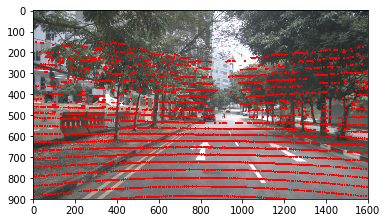

In [110]:
from nuscenes.utils.data_classes import LidarPointCloud
from PIL import Image
from data.kitti_helper import projection_pc_img

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


def get_calibration_P(nusc, sample_data):
    calib = nusc.get('calibrated_sensor', sample_data['calibrated_sensor_token'])
    R = np.asarray(Quaternion(calib['rotation']).rotation_matrix).astype(np.float32)
    t = np.asarray(calib['translation']).astype(np.float32)
    P = get_P_from_Rt(R, t)
    return P
    
def get_camera_K(nusc, camera):
    calib = nusc.get('calibrated_sensor', camera['calibrated_sensor_token'])
    return np.asarray(calib['camera_intrinsic']).astype(np.float32)


item = dataset_read[1000]
lidar_token = item[0]
nearby_cam_token_dict = item[1]

# load point cloud
lidar = nusc.get('sample_data', lidar_token) 
pc = LidarPointCloud.from_file(os.path.join(root_path, lidar['filename']))
pc_np = pc.points[0:3, :]
intensity_np = pc.points[3:4, :]
pc_np_homo = np.concatenate((pc_np, np.ones((1, pc_np.shape[1]), dtype=pc_np.dtype)), 
                            axis=0)
print(pc_np.shape)
print(intensity_np.shape)

lidar_calib_P = get_calibration_P(nusc, lidar)
lidar_pose_P = get_sample_data_ego_pose_P(nusc, lidar)


# load image
camera_name = 'CAM_FRONT'
camera = nusc.get('sample_data', nearby_cam_token_dict[camera_name][0])
img = Image.open(os.path.join(nusc.dataroot, camera['filename']))
img_np = np.array(img)
print(img_np.shape)

camera_calib_P = get_calibration_P(nusc, camera)
camera_pose_P = get_sample_data_ego_pose_P(nusc, camera)
camera_K = get_camera_K(nusc, camera)


camera_pose_P_inv = np.linalg.inv(camera_pose_P)
camera_calib_P_inv = np.linalg.inv(camera_calib_P)
P_cam_lidar = np.dot(camera_calib_P_inv, np.dot(camera_pose_P_inv, 
                      np.dot(lidar_pose_P, lidar_calib_P)))
pc_np_cam = np.dot(P_cam_lidar, pc_np_homo)[0:3, :]


img_vis = projection_pc_img(pc_np_cam, img_np, 
                            camera_K,
                            size=5)
plt.figure()
plt.imshow(img_vis)
plt.show()
